In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function
from __future__ import division
import datetime

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

## Data import and cleaning

#### Visually measured height

In [3]:
dfheight_measured = pd.read_csv('../data/interim/Height_measured.csv', parse_dates=['Date & Time'])
dfheight_measured

,Date & Time,Height in feet
0,2015-12-16,7
1,2015-12-19,Water stops
2,2015-12-21,8
3,2015-12-31,10
4,2016-01-18,12
5,2016-03-01,Water starts
6,2016-03-09,30
7,2016-03-22,58
8,2016-03-25,56
9,2016-03-31,42


#### Height measured from pictures

In [4]:
dfheight = pd.read_csv('../data/interim/Height_from_pictures.csv', index_col=0)
dfheight['picture_file'] = dfheight['Label'].apply(lambda x: x.replace('bloomsky images:', '')+'.jpg')
del dfheight['Label']
del dfheight['Angle'] # no trigonometric transformation needed
#dfheight.set_index('picture_file', inplace=True)
dfheight.rename(columns={'Length': 'height_pixels'}, inplace=True)
dfheight.head()

,height_pixels,picture_file
,,
1,113.667,5.jpg
2,115.333,6.jpg
3,116.000,7.jpg
4,117.000,8.jpg
5,117.667,9.jpg


#### Bloomsky environmental variables

In [5]:
dfbloomsky = pd.read_csv('../data/interim/Bloomsky_data.csv', parse_dates=['Time'])
dfbloomsky.rename(columns={'Time': 'time',
                           'Temperature(C)': 'temp',
                           'RH': 'rh',
                           'Pressure(mbar)': 'pressure',
                           'Unnamed: 6': 'picture_file'}, inplace=True)
dfbloomsky = dfbloomsky[[col for col in dfbloomsky.columns if not (col.startswith('Unnamed') or col.startswith('Image'))]]
dfbloomsky['picture_file'] = dfbloomsky['picture_file'].apply(lambda x: x.split('/')[-1])
dfbloomsky.head()

,time,temp,rh,UV Index,pressure,picture_file
0,2016-02-12 17:06:00,-0.60,26,1280,656.0,1.jpg
1,2016-02-13 07:53:00,-7.43,78,1273,659.0,2.jpg
2,2016-02-13 17:07:00,-2.21,30,1324,658.0,3.jpg
3,2016-02-14 17:05:00,1.25,10,1542,658.0,4.jpg
4,2016-02-16 07:54:00,-6.06,35,1277,665.0,5.jpg


#### Joining all data structures into one

In [6]:
df = pd.merge(dfbloomsky, dfheight, on='picture_file')
# equivalent to inner join: records with no corresponding pixel height will be deleted
df.sort_values('time', inplace=True)
df.head()

,time,temp,rh,UV Index,pressure,picture_file,height_pixels
0,2016-02-16 07:54:00,-6.06,35,1277,665.0,5.jpg,113.667
1,2016-02-16 17:04:00,0.74,16,1308,663.0,6.jpg,115.333
2,2016-02-18 17:07:00,7.56,4,1488,665.0,7.jpg,116.000
3,2016-02-19 07:56:00,-4.87,20,1307,669.0,8.jpg,117.000
4,2016-02-19 17:06:00,0.00,62,1285,666.0,9.jpg,117.667


Introducing date field in order to join DataFrame with feet measurements

In [7]:
df['date'] = df['time'].apply(lambda x: str(x.date()))

In [8]:
dfhm = dfheight_measured.rename(columns={'Date & Time': 'date', 'Height in feet': 'height_feet'})
dfhm = dfhm[(dfhm['height_feet']).str.isdigit()]
dfhm['date'] = dfhm['date'].apply(lambda x: str(x.date()))
dfhm['height_meters'] = dfhm['height_feet'].apply(lambda x: float(x)*0.3048)
del dfhm['height_feet']
dfhm.head()

,date,height_meters
0,2015-12-16,2.1336
2,2015-12-21,2.4384
3,2015-12-31,3.0480
4,2016-01-18,3.6576
6,2016-03-09,9.1440


In [9]:
df = pd.merge(df, dfhm, on='date', how='left')
df[pd.isnull(df['height_meters'])==False]

,time,temp,rh,UV Index,pressure,picture_file,height_pixels,date,height_meters
29,2016-03-09 07:54:00,-0.14,34,1313,665.0,35.jpg,159.667,2016-03-09,9.144
30,2016-03-09 17:05:00,8.59,11,1366,661.0,34.jpg,157.000,2016-03-09,9.144


In [10]:
conv_ratio = (df['height_meters']/df['height_pixels']).dropna().mean()
print('One metre corresponds to %0.2f pixels in the Bloomsky images' % (1.0/conv_ratio))

One metre corresponds to 17.31 pixels in the Bloomsky images


In [11]:
df['height_meters'] = df['height_pixels'].apply(lambda x: x*conv_ratio)
del df['date'], df['height_pixels']

#### Final processed data set

In [12]:
df.head()

,time,temp,rh,UV Index,pressure,picture_file,height_meters
0,2016-02-16 07:54:00,-6.06,35,1277,665.0,5.jpg,6.564907
1,2016-02-16 17:04:00,0.74,16,1308,663.0,6.jpg,6.661128
2,2016-02-18 17:07:00,7.56,4,1488,665.0,7.jpg,6.699651
3,2016-02-19 07:56:00,-4.87,20,1307,669.0,8.jpg,6.757407
4,2016-02-19 17:06:00,0.00,62,1285,666.0,9.jpg,6.795930


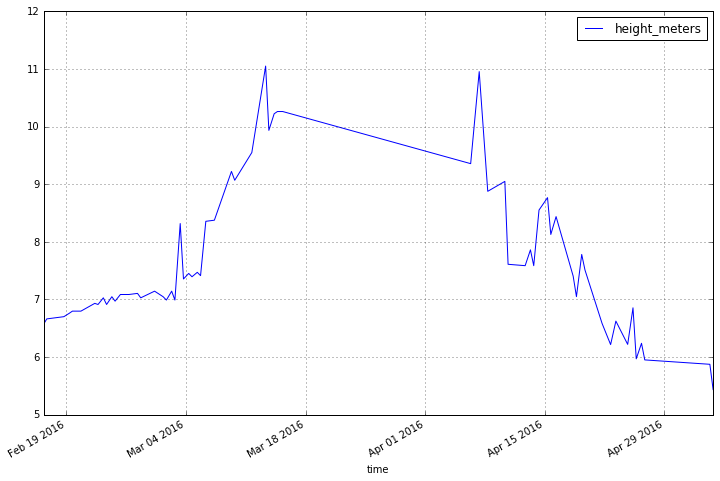

In [13]:
df[['time', 'height_meters']].set_index('time').plot(figsize=(12,8), grid=True);

Exporting data to CSV file

In [14]:
df.to_csv('../data/processed/icestupa_measurements.csv', index=False)